In [6]:
import sys
import time
import bibtexparser
import itertools
import requests
import re
import pandas as pd
from bs4 import BeautifulSoup

In [2]:
import bibtexparser
bibtex_file = open('gap-publishednicer.bib.txt', encoding='utf-8')
bib_data = bibtexparser.load(bibtex_file)

In [106]:
bib = bib_data.entries

In [163]:
bib_df = pd.DataFrame.from_dict(bib)
review_df = pd.read_csv('no_citation_text.csv', dtype='str')
corpus_df = pd.read_csv('gap_citations_corpus.csv', dtype='str')

In [164]:
bib_df.columns

Index(['printedkey', 'doi', 'url', 'mrreviewer', 'mrnumber', 'mrclass', 'issn',
       'fjournal', 'pages', 'year', 'volume', 'journal', 'title', 'author',
       'ENTRYTYPE', 'ID', 'number', 'school', 'booktitle', 'isbn', 'note',
       'publisher', 'day', 'keywords', 'month', 'series', 'annote', 'type',
       'address', 'institution', 'howpublished', 'editor', 'bookeditor',
       'edition', 'key', 'organization'],
      dtype='object')

# Larger dataset from Bibliography

We only need some of these columns, hence we `drop` the rest.

In [169]:
bib_df.drop(bib_df.columns[[0, 1, 2, 3, 5, 6, 7, 8, 10, 12, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]], axis = 1, inplace = True)

In [170]:
bib_df.columns

Index(['mrnumber', 'year', 'journal', 'author', 'ENTRYTYPE'], dtype='object')

In [172]:
bib_df = bib_df[['mrnumber', 'author', 'journal', 'year', 'ENTRYTYPE']]

Then we change the `mrnumber` coulmn name to `MRN` so we cane later merge this dataframe with the other one.

In [173]:
bib_df.columns = ['MRN', 'author', 'journal', 'year', 'ENTRYTYPE']

In [178]:
bib_df.head(7)

,MRN,author,journal,year,ENTRYTYPE
0,4056124,"Abas, M. and Vetrík, T.",Theoret. Comput. Sci.,2020,article
1,3942387,"Abbas, A. and Assi, A. and García-Sánchez, P. A.",Rev. R. Acad. Cienc. Exactas Fís. Nat. Ser. A ...,2019,article
2,NaN,"Abdeljaouad, I.",RAIRO-INF THEOR APPL,1999,article
3,3354065,"Abdolghafourian, A. and Iranmanesh, M. A.",Comm. Algebra,2015,article
4,3646312,"Abdolghafourian, A. and Iranmanesh, M. A. and ...",J. Pure Appl. Algebra,2017,article
5,1864795,"Abdollahi, A.",Houston J. Math.,2001,article
6,2371966,"Abdollahi, A.",J. Algebra,2007,article


Data types and count of non-null values for each columns.

In [180]:
bib_df.info(show_counts  = True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3367 entries, 0 to 3366
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   MRN        3159 non-null   object
 1   author     3367 non-null   object
 2   journal    3047 non-null   object
 3   year       3367 non-null   object
 4   ENTRYTYPE  3367 non-null   object
dtypes: object(5)
memory usage: 65.8+ KB


Looking at the `MRN` columns, some cells are empty - `NaN`

In [177]:
bib_df.iloc[3274]

MRN                    NaN
author          Wegner, A.
journal                NaN
year                  1989
ENTRYTYPE    mastersthesis
Name: 3274, dtype: object

In [122]:
bib_df.describe()

,ID,author,journal,year,ENTRYTYPE
count,3367,3367,3047,3367,3367
unique,3366,2511,384,43,10
top,MR3656296,"Sambale, B.",J. Algebra,2017,article
freq,2,18,387,188,2976


##### We will look at the `year` coulumn. There are several anomalies and we need just 4 digits in each cell.

In [181]:
bib_df.sort_values('year', ascending=False)

,MRN,author,journal,year,ENTRYTYPE
3165,3973299,"Then, H.",NaN,[2019] \copyright 2019,incollection
1546,3898507,"Greer, M.",NaN,[2019] \copyright 2019,incollection
3133,3898514,"Stuhl, I. and Vojtěchovský, P.",NaN,[2019] \copyright 2019,incollection
3147,3782458,"Swinarski, D.",NaN,[2018] \copyright 2018,incollection
1981,4167659,"Kaushik, R. and Yadav, M. K.",J. Algebra,2021,article
...,...,...,...,...,...
3274,NaN,"Wegner, A.",NaN,1989,mastersthesis
2689,NaN,"Niemeyer, A.",NaN,1988,mastersthesis
2673,NaN,"Nickel, W.",NaN,1988,mastersthesis
3018,NaN,"Schönert, M.",NaN,1987,mastersthesis


We will use `.str` and a regular expresion `(r'^(\d{4})'` which first converts all year cells to strings then takes the first 4 digits from each. We then replace the old values with the filtered ones.

In [184]:
bib_df['year'] = bib_df['year'].str.extract(r'^(\d{4})', expand=False)

In [185]:
bib_df['year'].value_counts()

2017    188
2013    175
2018    168
2020    166
2019    165
2010    163
2015    162
2016    158
2014    154
2011    152
2007    142
2012    142
2008    132
2004    131
2005    128
2009    124
2006    118
2001    107
2003    101
1999     84
2002     84
2000     78
1997     76
1998     58
1995     56
2021     39
1996     34
1994     28
1993     25
1992     13
1991      5
1987      2
1988      2
1989      2
1990      1
Name: year, dtype: int64

We inspect the result and no more anomalies are visible. Data type is integer which is also fine.

In [186]:
bib_df['year'].describe()

count     3363
unique      35
top       2017
freq       188
Name: year, dtype: object

Barchart dislaying number of GAP citations per year.

<AxesSubplot:>

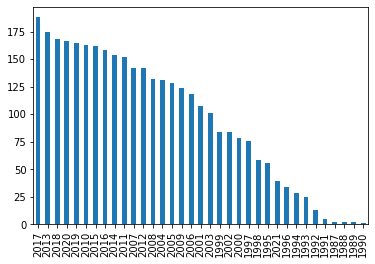

In [152]:
bib_df['year'].value_counts().plot(kind="bar")

In [190]:
top_journals = bib_df.sort_values('year', ascending=False)

In [191]:
top_journals[:20]

,MRN,author,journal,year,ENTRYTYPE
1644,4208094,"Hauck, P. and Kazarin, L. S. and Martínez-Past...",Ann. Mat. Pura Appl. (4),2021,article
186,4163065,"Araújo, J. and Bentz, W. and Cameron, P. J.",J. Algebra,2021,article
2303,4196561,"Lübeck, F. and Prasad, D.",J. Combin. Theory Ser. A,2021,article
1519,4186638,"Gow, R. and Murray, J.",J. Algebra,2021,article
2845,4204560,"Posur, S.",Appl. Categ. Structures,2021,article
2115,4213626,"Koshitani, S. and Lassueur, C.",J. Algebra,2021,article
1362,4192835,"Gaddis, J. and Rogalski, D.",J. Pure Appl. Algebra,2021,article
2560,4187238,"Morgan, L. and Morris, J. and Verret, G.",J. Algebra,2021,article
2775,4200815,"Pan, H. and Hung, N. N. and Yang, Y.",J. Pure Appl. Algebra,2021,article
737,4203538,"Carocca, Á. and Hidalgo, R. A. and Rodríguez, ...",J. Algebra,2021,article


In [83]:
bib_df['ENTRYTYPE'].describe()

count        3367
unique         10
top       article
freq         2976
Name: ENTRYTYPE, dtype: object

In [120]:
bib_df['ENTRYTYPE'].value_counts()

article          2976
incollection      204
inproceedings      54
phdthesis          47
mastersthesis      46
book               31
misc                5
techreport          2
inbook              1
manual              1
Name: ENTRYTYPE, dtype: int64

##### The most frequent type of work citing GAP is article.

<AxesSubplot:>

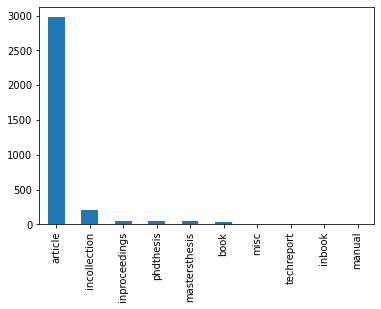

In [84]:
bib_df['ENTRYTYPE'].value_counts().plot(kind="bar") # base from leccture 8 CS2006

Top 20 journals citing GAP.

In [189]:
bib_df['journal'].describe

<bound method NDFrame.describe of 0                                   Theoret. Comput. Sci.
1       Rev. R. Acad. Cienc. Exactas Fís. Nat. Ser. A ...
2                                    RAIRO-INF THEOR APPL
3                                           Comm. Algebra
4                                   J. Pure Appl. Algebra
                              ...                        
3362                                       J. Geom. Phys.
3363                                           J. Algebra
3364                                           J. Algebra
3365                                 Linear Algebra Appl.
3366                                    Sibirsk. Mat. Zh.
Name: journal, Length: 3367, dtype: object>

In [159]:
bib_df.sort_values('journal')

,MR,author,journal,year,ENTRYTYPE
1931,joyner2004d,"Joyner, D. and Traves, W.",(submitted),2004,article
1928,joyner2004f,"Joyner, D. and Ksir, A.",(submitted),2004,article
1932,joyner2004c,"Joyner, D. and Verrill, H.",(submitted),2004,article
2092,Kon01,"Konovalov, A. B.",3rd Internat. Conf. on Algebra in Ukraine,2001,article
1169,effenberger2011,"Effenberger, F. and Spreer, J.",ACM Communications in Computer Algebra,2011,article
...,...,...,...,...,...
3301,wondratschek2004a,"Wondratschek, H. and Müller, U.",NaN,2004,book
3310,wright2003c,"Wright, D.",NaN,2003,inproceedings
3354,MR3905073,"Zidaric, N. and Aagaard, M. and Gong, G.",NaN,2018,incollection
3355,Ziegler93,"Ziegler, G.",NaN,1993,mastersthesis


In [154]:
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
interact(f, x=['apples','oranges']);

#  Corpus and Review

To do
+ check Citations strings lenghts to isolate too short ones
+ version
+ website
+ remaining HTML characters

In [20]:
corpus_df

,MR,Citation
0,MR4056124,"GAP – Groups, algorithms, programming - a syst..."
1,MR3942387,"Delgado, M., García-Sánchez, P.A., Morais, J.:..."
2,MR3942387,"The GAP Group: GAP—groups, algorithms, and pro..."
3,MR3354065,"The GAP – Groups, Algorithms and Programming. ..."
4,MR3646312,"The $\ssf{GAP}$ Group, $\ssf{GAP}$–Groups, Alg..."
...,...,...
3537,MR3988630,"M. Delgado, P. A. García-Sánchez and J. Morais..."
3538,MR1801202,"L.H. Soicher, GRAPE: a system for computing wi..."
3539,MR2558870,"L. Bartholdi, Functionally recursive groups, h..."
3540,MR2824780,"X. Sun, C. Liu, D. Li and J. Gao, On duality g..."


In [49]:
print(corpus_df[corpus_df['MR'].str.contains("MR3942387")])

          MR                                           Citation
1  MR3942387  Delgado, M., García-Sánchez, P.A., Morais, J.:...
2  MR3942387  The GAP Group: GAP—groups, algorithms, and pro...


In [50]:
exa = corpus_df[corpus_df['MR'].str.contains("MR3942387")]

In [57]:
exa.iloc[0]['Citation']

'Delgado, M., García-Sánchez, P.A., Morais, J.: "Numerical Sgps", A GAP package for numerical semi-groups. https://gap-packages.github.io/numericalsgps. Accessed 19 Aug 2017 \nMR3493240'

In [58]:
exa.iloc[1]['Citation']

'The GAP Group: GAP—groups, algorithms, and programming, version 4.7.5 (2014). http://www.gap-system.org. Accessed 19 Aug 2017'

In [59]:
exa1 = corpus_df[corpus_df['MR'].str.contains("MR2822510")]

In [60]:
exa1

,MR,Citation
3523,MR2822510,http://www.gap-system.org.


df = pd.DataFrame(lis_dic)
df = df[df.ID.isin(targets)]

df_filtered = df[df.mrnumber.isin(mrs)]

# Merging the two dataframes with the equivalent of SQL `join`

In [121]:
merged_df = pd.merge(bib_df,corpus_df,on='ID',how='outer',indicator=True)

KeyError: 'ID'